In [1]:
# Data
import yfinance as yf
import yahooquery
import pandas_datareader as pdr
import pandas_market_calendars as mcal

# Maths
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint

# Visualization
from matplotlib import pyplot as plt

# Data handling
import numpy as np
import pandas as pd

# Utility
import datetime

In [10]:
def Get_top_10_ETF_symbols(ETF):
    holdings = yahooquery.Ticker(ETF).fund_holding_info[ETF]['holdings']
    return [holding['symbol'] for holding in holdings]
def Get_ETF_data(ETF):
    tickers = Get_top_10_ETF_symbols(ETF)
    df = yf.download(tickers, start=valid_start_day)['Close']
    df = df.dropna(axis=0, how='any')
    return df

In [26]:
# Date and Time
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=900)
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

# List of ETF: https://en.wikipedia.org/wiki/List_of_American_exchange-traded_funds 

#SMH_top_10_tickers = Get_top_10_ETF_symbols('SMH') # VanEck Semiconductor ETF    #####Seems work#####
#AMLP_top_10_tickers = Get_top_10_ETF_symbols('AMLP') # energy, ALPS Alerian MLP ETF   #####Seems work#####
#VDE_top_10_tickers = Get_top_10_ETF_symbols('VDE') # Vanguard Energy  
#XLF_top_10_tickers = Get_top_10_ETF_symbols('XLF') # Financial Select Sector SPDR
#VOO_top_10_tickers = Get_top_10_ETF_symbols('VOO') # Vanguard S&P 500 ETF

# Download data
df = Get_ETF_data('SMH')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [28]:
df.tail(5)

Ticker,ADI,AMAT,AMD,ASML,AVGO,LRCX,NVDA,QCOM,TSM,TXN
Date,,,,,,,,,,
2025-02-14,214.610001,169.199997,113.099998,751.549988,233.039993,82.750000,138.850006,172.229996,203.899994,183.029999
2025-02-18,220.220001,172.000000,114.279999,744.219971,228.529999,86.580002,139.399994,173.639999,202.740005,186.460007
2025-02-19,241.660004,174.059998,114.690002,744.799988,228.729996,87.660004,139.229996,175.220001,200.949997,196.320007
2025-02-20,243.820007,176.009995,114.169998,743.090027,226.740005,89.019997,140.110001,173.699997,200.100006,203.960007
2025-02-21,238.910004,171.979996,110.839996,737.210022,218.660004,86.019997,134.429993,165.429993,198.240005,202.000000


In [30]:
# Split data
def Log_return(df): # We use log return as the time series instead of the stock itself (got more nicer properties!)
    return np.log(df/df.shift(1)).dropna()
TT_split = 0.8 #you need constant update so Train-test split must be large to see good result

def Log_price(df):
    return np.log(df).dropna()

Train_df = df[:int(len(df)*TT_split)]
Train_df_return = Log_return(Train_df)
Train_df_Log_price = Log_price(Train_df)

Test_df = df[int(len(df)*TT_split):]

# Trading method
1) Trade at close
2) Long or Short a certine number of stocks every day based on mean reversion
3) z-entry and z-exit remain static
5) Simple fixed feed: transaction cost 2% (include brorrow fee)

# Pre-Trading:

## Cointegrated pair
1) Check for cointegrated pair using log-price
2) For each cointegrated pair using Train data set, do ADF test for stationarity of the sperad.

## Hedge ratio

Runs Ordinary Least Squares regression using training data for the pair.

The model:
$$
S_1 = \beta*S_2 + \epsilon
$$

we will use the $\beta$ from train and use it on test set

## Mean Reversion Target:

For Long S1 positions: $z$-score < -exit_threshold

For Short S1 positions: $z$-score > exit_threshold

# Entry Conditions:
The strategy enters a position when the $z$-score of the spread exceeds a threshold ($|z| >$ entry_threshold)

================================================================================

For a $z$-score > +entry_threshold:

    Short S1, Long S2 (mean-reversion expectation)
    
Position sizes: 

1) $S_1$ shares = -0.5 × capital / $P_1$
2) $S_2$ shares = hedge_ratio × |$S_1$ shares|

--------------------------------------------------------------------------------

For a $z$-score < -entry_threshold:

    Long S1, Short S2
    
Position sizes: 

1) $S_1$ shares = +0.5 × capital / $P_1$
2) $S_2$ shares = -hedge_ratio × |$S_1$ shares|

================================================================================

## Position Sizing

Each pair is allocated equal capital: capital_per_pair = initial_capital / n_pairs

For each trade, 50% of available capital is used per leg
Position value calculation:
$$
V = |S_1 \times P_1| + |S_1 \times P_2|
$$

$$
\mathrm{Transaction costs} = V \times \mathrm{transaction \ cost \%}
$$

## Exit Conditions

Stop Loss: Return $\leq$ -stop loss %, where

Return = ($S_1$ × ($P_{1,\mathrm{current}} - P_{1,\mathrm{entry}}$) + $S_2$ × ($P_{2,\mathrm{current}} - P_{2,\mathrm{entry}}$)]) / $V_\mathrm{entry}$

Take Profit: Return $\geq$ take profit %

In [116]:
def find_cointegrated_pairs(df, p_threshold=0.10):  # Relaxed p-value threshold
    n = df.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = df.keys()
    pairs = []

    df_log = df
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = df_log[keys[i]]
            S2 = df_log[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < p_threshold:
                pairs.append({
                    'S1': keys[i],
                    'S2': keys[j],
                    'score': score,
                    'pvalue': pvalue
                })
                
    return score_matrix, pvalue_matrix, pairs

In [168]:
def analyze_spreads(df, pairs, window=30):
    analyzed_pairs = []
    
    for pair in pairs:
        S1 = df[pair['S1']]
        S2 = df[pair['S2']]
        
        # Calculate hedge ratio using OLS
        X = sm.add_constant(S2)
        model = sm.OLS(S1, X)
        result = model.fit()
        
        hedge_ratio = result.params.iloc[1]  # Using iloc for positional indexing
        
        # Calculate spread
        spread = S1 - hedge_ratio * S2
        
        # Perform ADF test on spread
        adf_result = adfuller(spread)
        
        # Calculate half-life of mean reversion
        spread_lag = spread.shift(1)
        delta_spread = spread - spread_lag
        X_lag = sm.add_constant(spread_lag[1:])
        model = sm.OLS(delta_spread[1:], X_lag)
        res = model.fit()
        
        half_life = -np.log(2) / res.params.iloc[1]  # Using iloc for positional indexing
        
        pair_analysis = {
            'S1': pair['S1'],
            'S2': pair['S2'],
            'hedge_ratio': hedge_ratio,
            'adf_statistic': adf_result[0],
            'adf_pvalue': adf_result[1],
            'half_life': half_life,
            'spread_mean': spread.mean(),
            'spread_std': spread.std()
        }
        
        analyzed_pairs.append(pair_analysis)
    
    return analyzed_pairs

def filter_best_pairs(analyzed_pairs):
    good_pairs = []
    
    for pair in analyzed_pairs:
        if (pair['adf_pvalue'] < 0.05 and 
            5 <= pair['half_life'] <= 60):
            
            good_pairs.append(pair)
            print('--------------------------------------------------------------------------')
            print(f"Found pair: {pair['S1']}-{pair['S2']}")
            print(f"ADF p-value: {pair['adf_pvalue']:.3f}, beta: {pair['hedge_ratio']:.3f}")
            print('--------------------------------------------------------------------------')
    return good_pairs

In [170]:
def implement_pairs_trading(df, pairs, initial_capital=100000, transaction_cost_pct=0.001, 
                          entry_threshold=1.0, exit_threshold=1.0, window=30,
                          stop_loss_pct=0.03, take_profit_pct=0.05):
    
    def calculate_position_return(current_S1_price, current_S2_price, entry_S1_price, entry_S2_price, 
                                S1_shares, S2_shares):
        """Calculate return for the pair position"""
        S1_pnl = (current_S1_price - entry_S1_price) * S1_shares
        S2_pnl = (current_S2_price - entry_S2_price) * S2_shares
        initial_value = abs(entry_S1_price * S1_shares) + abs(entry_S2_price * S2_shares)
        return (S1_pnl + S2_pnl) / initial_value

    portfolio = pd.DataFrame(index=df.index)
    portfolio['total_value'] = initial_capital
    portfolio['cash'] = initial_capital
    portfolio['positions_value'] = 0.0
    
    pair_performances = {}
    all_trades = {}
    capital_per_pair = initial_capital / len(pairs)
    
    for pair in pairs:
        S1_symbol = pair['S1']
        S2_symbol = pair['S2']
        hedge_ratio = pair['hedge_ratio']
        pair_name = f"{S1_symbol}-{S2_symbol}"
        
        # Get price series
        S1_prices = df[S1_symbol]
        S2_prices = df[S2_symbol]
        
        # Calculate z-scores
        spread = S1_prices - hedge_ratio * S2_prices
        rolling_mean = spread.rolling(window=window).mean()
        rolling_std = spread.rolling(window=window).std()
        zscore = (spread - rolling_mean) / rolling_std
        
        # Initialize pair tracking
        pair_data = pd.DataFrame(index=df.index)
        pair_data['zscore'] = zscore
        pair_data['S1_position'] = 0.0
        pair_data['S2_position'] = 0.0
        pair_data['cash'] = capital_per_pair
        pair_data['total_value'] = capital_per_pair
        pair_data['returns'] = 0.0
        
        # Trading variables
        in_position = False
        entry_S1_price = 0
        entry_S2_price = 0
        S1_shares = 0
        S2_shares = 0
        trades = []
        
        # Implement trading logic
        for i in range(window, len(df)):
            current_zscore = zscore.iloc[i]
            current_S1_price = S1_prices.iloc[i]
            current_S2_price = S2_prices.iloc[i]
            
            if not in_position:
                # Check for entry signal
                if abs(current_zscore) > entry_threshold:
                    # Calculate position sizes
                    available_capital = pair_data['cash'].iloc[i-1]
                    position_size = available_capital * 0.5  # Use half capital for each leg
                    
                    # Determine direction
                    direction = -1 if current_zscore > entry_threshold else 1
                    
                    # Calculate shares
                    S1_shares = (position_size / current_S1_price) * direction
                    S2_shares = (-hedge_ratio * S1_shares)  # Opposite direction
                    
                    # Record entry prices
                    entry_S1_price = current_S1_price
                    entry_S2_price = current_S2_price
                    
                    # Calculate transaction costs
                    position_value = abs(S1_shares * current_S1_price) + abs(S2_shares * current_S2_price)
                    transaction_cost = position_value * transaction_cost_pct
                    
                    # Update positions and cash
                    pair_data.loc[df.index[i], 'S1_position'] = S1_shares
                    pair_data.loc[df.index[i], 'S2_position'] = S2_shares
                    pair_data.loc[df.index[i], 'cash'] = available_capital - transaction_cost
                    
                    in_position = True
                    entry_date = df.index[i]
                
                else:
                    # No position, forward fill
                    pair_data.loc[df.index[i]] = pair_data.iloc[i-1]
            
            else:
                # In position, check exit conditions
                position_return = calculate_position_return(
                    current_S1_price, current_S2_price,
                    entry_S1_price, entry_S2_price,
                    S1_shares, S2_shares
                )
                
                # Check stop loss and take profit
                exit_signal = (position_return <= -stop_loss_pct or 
                             position_return >= take_profit_pct or
                             (S1_shares > 0 and current_zscore < -exit_threshold) or
                             (S1_shares < 0 and current_zscore > exit_threshold))
                
                if exit_signal:
                    # Calculate exit value and costs
                    exit_value = (S1_shares * current_S1_price + 
                                S2_shares * current_S2_price)
                    transaction_cost = abs(exit_value) * transaction_cost_pct
                    
                    # Record trade
                    trades.append({
                        'entry_date': entry_date,
                        'exit_date': df.index[i],
                        'entry_S1_price': entry_S1_price,
                        'entry_S2_price': entry_S2_price,
                        'exit_S1_price': current_S1_price,
                        'exit_S2_price': current_S2_price,
                        'S1_shares': S1_shares,
                        'S2_shares': S2_shares,
                        'return': position_return * 100,  # Convert to percentage
                        'duration': (df.index[i] - entry_date).days
                    })
                    
                    # Update positions and cash
                    pair_data.loc[df.index[i], 'S1_position'] = 0
                    pair_data.loc[df.index[i], 'S2_position'] = 0
                    pair_data.loc[df.index[i], 'cash'] = (
                        pair_data['cash'].iloc[i-1] + exit_value - transaction_cost
                    )
                    
                    in_position = False
                    S1_shares = 0
                    S2_shares = 0
                
                else:
                    # Update values
                    pair_data.loc[df.index[i], 'S1_position'] = S1_shares
                    pair_data.loc[df.index[i], 'S2_position'] = S2_shares
                    pair_data.loc[df.index[i], 'cash'] = pair_data['cash'].iloc[i-1]
            
            # Update total value
            pair_data.loc[df.index[i], 'total_value'] = (
                pair_data['cash'].iloc[i] +
                pair_data['S1_position'].iloc[i] * current_S1_price +
                pair_data['S2_position'].iloc[i] * current_S2_price
            )
            
            # Calculate returns
            if i > window:
                pair_data.loc[df.index[i], 'returns'] = (
                    pair_data['total_value'].iloc[i] / pair_data['total_value'].iloc[i-1] - 1
                )
        
        # Store pair performance and trades separately
        pair_performances[pair_name] = pair_data
        all_trades[pair_name] = trades
        
        # Update portfolio values
        portfolio['positions_value'] += (
            pair_data['S1_position'] * df[S1_symbol] +
            pair_data['S2_position'] * df[S2_symbol]
        )
        portfolio['cash'] += pair_data['cash'] - capital_per_pair
        portfolio['total_value'] = portfolio['cash'] + portfolio['positions_value']
    
    return portfolio, pair_performances, all_trades

def calculate_rolling_hedge_ratio(S1, S2, window=60):
    """Calculate rolling hedge ratio using only past data"""
    hedge_ratios = pd.Series(index=S1.index, dtype=float)
    
    for i in range(window, len(S1)):
        # Use only past data for regression
        y = S1.iloc[i-window:i]
        X = S2.iloc[i-window:i]
        X = sm.add_constant(X)
        
        model = sm.OLS(y, X).fit()
        hedge_ratios.iloc[i] = model.params[1]
    
    return hedge_ratios

def run_backtest(train_df, test_df, entry_threshold=1.0, exit_threshold=1.0, zscore_window=30):
    """
    train_df: DataFrame for training period
    test_df: DataFrame for testing period
    """
    # Find cointegrated pairs using only training data
    _, _, raw_pairs = find_cointegrated_pairs(np.log(train_df), p_threshold=0.10)
    analyzed_pairs = analyze_spreads(train_df, raw_pairs)
    pairs = filter_best_pairs(analyzed_pairs)

    # Calculate hedge ratios using only training data
    pairs_with_ratios = []
    for pair in pairs:
        S1 = train_df[pair['S1']]
        S2 = train_df[pair['S2']]
        
        # Calculate hedge ratio using training data only
        X = sm.add_constant(S2)
        model = sm.OLS(S1, X).fit()
        hedge_ratio = model.params[1]
        
        pairs_with_ratios.append({
            'S1': pair['S1'],
            'S2': pair['S2'],
            'hedge_ratio': hedge_ratio,
            'adf_pvalue': pair['adf_pvalue']
        })
    
    # Run the trading strategy on test data
    portfolio, pair_performances, all_trades = implement_pairs_trading(
        df=test_df,
        pairs=pairs_with_ratios,
        initial_capital=10000,
        transaction_cost_pct=0.001,
        entry_threshold=entry_threshold,
        exit_threshold=exit_threshold,
        window=zscore_window
    )
    
    return portfolio, pair_performances, all_trades

def analyze_performance(portfolio, pair_performances, all_trades):
    """Analyze overall portfolio and pair performance"""
    
    # Calculate portfolio-level metrics
    total_return = (portfolio['total_value'].iloc[-1] / portfolio['total_value'].iloc[0] - 1) * 100
    daily_returns = portfolio['total_value'].pct_change().dropna()
    
    annualized_return = (1 + total_return/100) ** (252/len(daily_returns)) - 1
    annualized_vol = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    
    # Calculate drawdown
    rolling_max = portfolio['total_value'].cummax()
    drawdown = (portfolio['total_value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min() * 100
    
    # Calculate pair-specific metrics
    pair_metrics = {}
    for pair_name, pair_data in pair_performances.items():
        trades = all_trades[pair_name]
        
        # Calculate total P&L
        total_pnl = pair_data['total_value'].iloc[-1] - pair_data['total_value'].iloc[0]
        
        # Calculate metrics from trades
        if trades:
            returns = [t['return'] for t in trades]
            
            # Calculate dollar P&L for each trade
            dollar_pnls = []
            for trade in trades:
                # Calculate initial position value
                initial_value = (abs(trade['S1_shares'] * trade['entry_S1_price']) + 
                               abs(trade['S2_shares'] * trade['entry_S2_price']))
                # Calculate dollar P&L
                dollar_pnl = initial_value * (trade['return'] / 100)
                dollar_pnls.append(dollar_pnl)
            
            win_rate = sum(1 for r in returns if r > 0) / len(returns) * 100
            avg_return = np.mean(returns)
            best_trade = max(returns)
            worst_trade = min(returns)
            best_trade_dollar = max(dollar_pnls)
            worst_trade_dollar = min(dollar_pnls)
        else:
            win_rate = 0
            avg_return = 0
            best_trade = 0
            worst_trade = 0
            best_trade_dollar = 0
            worst_trade_dollar = 0
        
        pair_metrics[pair_name] = {
            'total_pnl': total_pnl,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'avg_return_per_trade': avg_return,
            'best_trade': best_trade,
            'worst_trade': worst_trade,
            'best_trade_dollar': best_trade_dollar,
            'worst_trade_dollar': worst_trade_dollar
        }
    
    # Print results
    print("\nPortfolio Performance Metrics:")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {annualized_return*100:.2f}%")
    print(f"Annualized Volatility: {annualized_vol*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    
    print("\nPair-specific Performance:")
    for pair_name, metrics in pair_metrics.items():
        print(f"\n{pair_name}:")
        print(f"Total P&L: ${metrics['total_pnl']:.2f}")
        print(f"Number of Trades: {metrics['num_trades']}")
        print(f"Win Rate: {metrics['win_rate']:.2f}%")
        print(f"Average Return per Trade: {metrics['avg_return_per_trade']:.2f}%")
        print(f"Best Trade: {metrics['best_trade']:.2f}% (${metrics['best_trade_dollar']:.2f})")
        print(f"Worst Trade: {metrics['worst_trade']:.2f}% (${metrics['worst_trade_dollar']:.2f})")
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot portfolio value
    plt.subplot(2, 1, 1)
    portfolio['total_value'].plot(title='Portfolio Value Over Time')
    plt.grid(True)
    plt.ylabel('Portfolio Value ($)')
    
    # Plot drawdown
    plt.subplot(2, 1, 2)
    drawdown.plot(title='Portfolio Drawdown', color='red')
    plt.grid(True)
    plt.ylabel('Drawdown (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Plot individual pair performances
    plt.figure(figsize=(15, 6))
    for pair_name, pair_data in pair_performances.items():
        pair_data['total_value'].plot(label=pair_name)
    plt.title('Individual Pair Performance')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_vol': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'pair_metrics': pair_metrics
    }

def analyze_trades(all_trades):
    """Analyze individual trades for each pair"""
    trade_stats = {}
    
    for pair_name, trades in all_trades.items():
        if trades:
            returns = [t['return'] for t in trades]
            durations = [t['duration'] for t in trades]
            
            trade_stats[pair_name] = {
                'num_trades': len(trades),
                'avg_return': np.mean(returns),
                'avg_duration': np.mean(durations),
                'win_rate': sum(1 for r in returns if r > 0) / len(returns) * 100,
                'best_trade': max(returns),
                'worst_trade': min(returns)
            }
            
            # Print detailed trade analysis
            print(f"\nDetailed Trade Analysis for {pair_name}:")
            print(f"Number of Trades: {len(trades)}")
            print(f"Average Return per Trade: {np.mean(returns):.2f}%")
            print(f"Average Trade Duration: {np.mean(durations):.1f} days")
            print(f"Win Rate: {trade_stats[pair_name]['win_rate']:.2f}%")
            print(f"Best Trade: {max(returns):.2f}%")
            print(f"Worst Trade: {min(returns):.2f}%")
            
            # Plot trade returns distribution
            plt.figure(figsize=(10, 6))
            plt.hist(returns, bins=20, alpha=0.7)
            plt.axvline(x=0, color='r', linestyle='--')
            plt.title(f'Trade Returns Distribution - {pair_name}')
            plt.xlabel('Return (%)')
            plt.ylabel('Number of Trades')
            plt.grid(True)
            plt.show()
    
    return trade_stats

In [172]:
portfolio, pair_performances, all_trades = run_backtest(Train_df, Test_df,entry_threshold=1.0, exit_threshold=0.5)

--------------------------------------------------------------------------
Found pair: ADI-TSM
ADF p-value: 0.006, beta: 0.680
--------------------------------------------------------------------------


/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_50954/2852536120.py:207: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]



Portfolio Performance Metrics:
Total Return: 5464.22%
Annualized Return: 376561.29%
Annualized Volatility: 145.53%
Sharpe Ratio: 6.44
Maximum Drawdown: -40.83%

Pair-specific Performance:

ADI-TSM:
Total P&L: $546422.45
Number of Trades: 33
Win Rate: 57.58%
Average Return per Trade: 0.02%
Best Trade: 5.02% ($28948.97)
Worst Trade: -6.33% ($-47924.67)


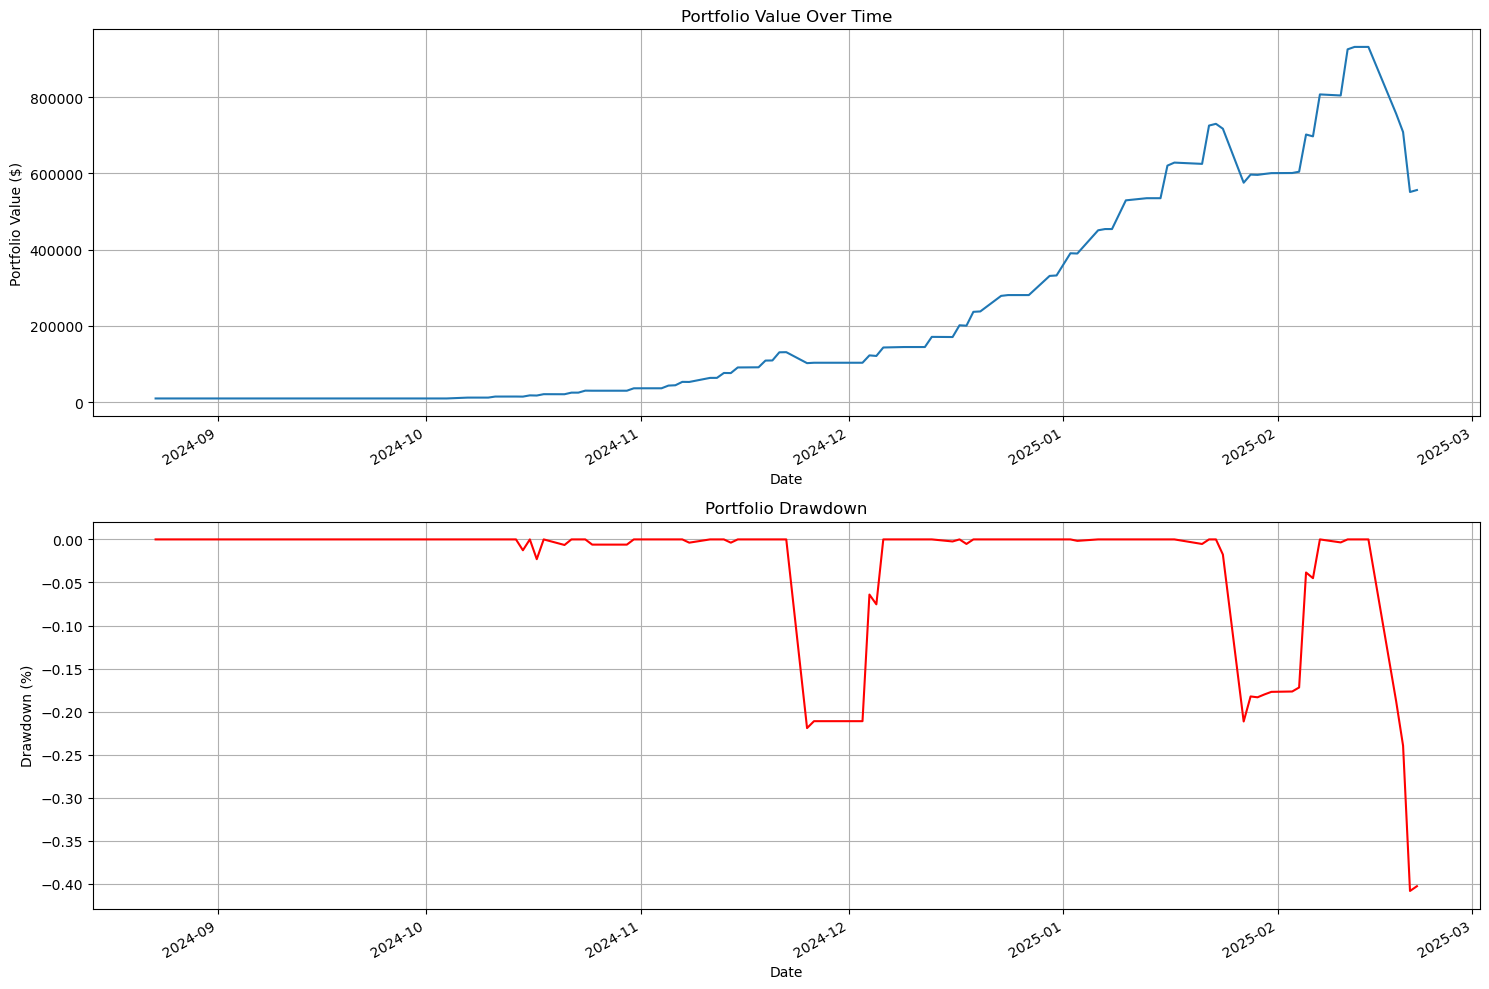

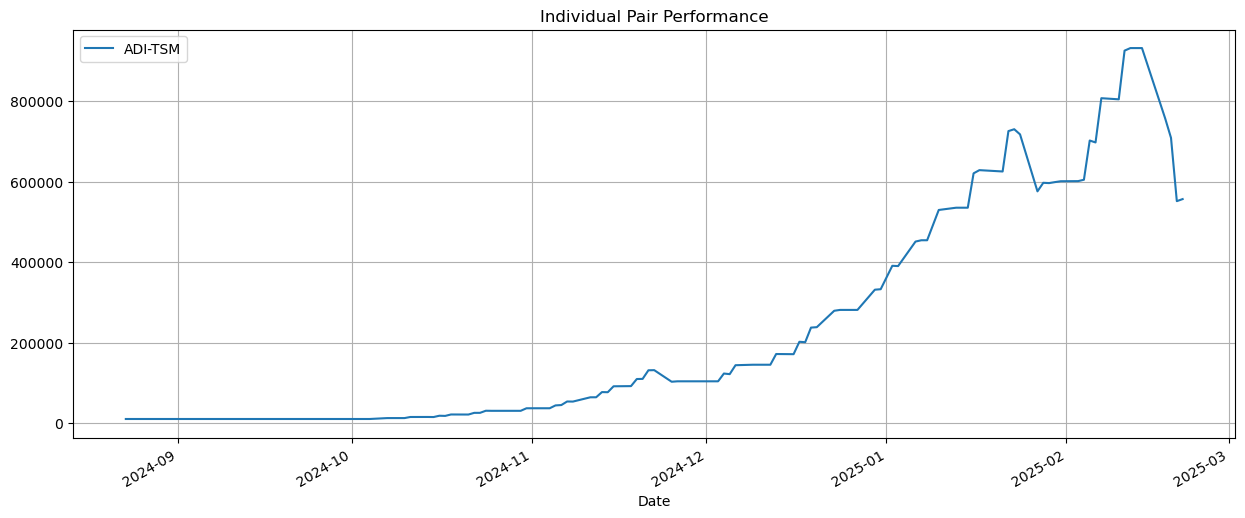


Detailed Trade Analysis for ADI-TSM:
Number of Trades: 33
Average Return per Trade: 0.02%
Average Trade Duration: 1.8 days
Win Rate: 57.58%
Best Trade: 5.02%
Worst Trade: -6.33%


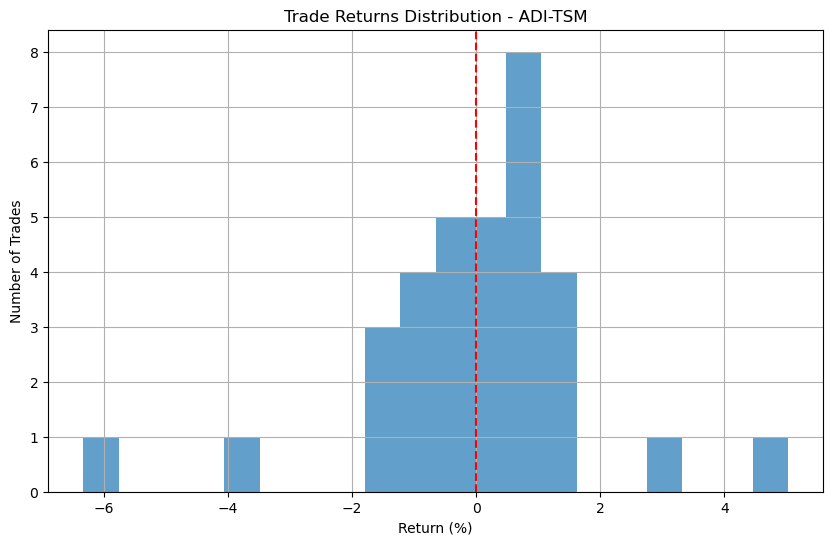

In [174]:
performance_metrics = analyze_performance(portfolio, pair_performances, all_trades)
trade_statistics = analyze_trades(all_trades)

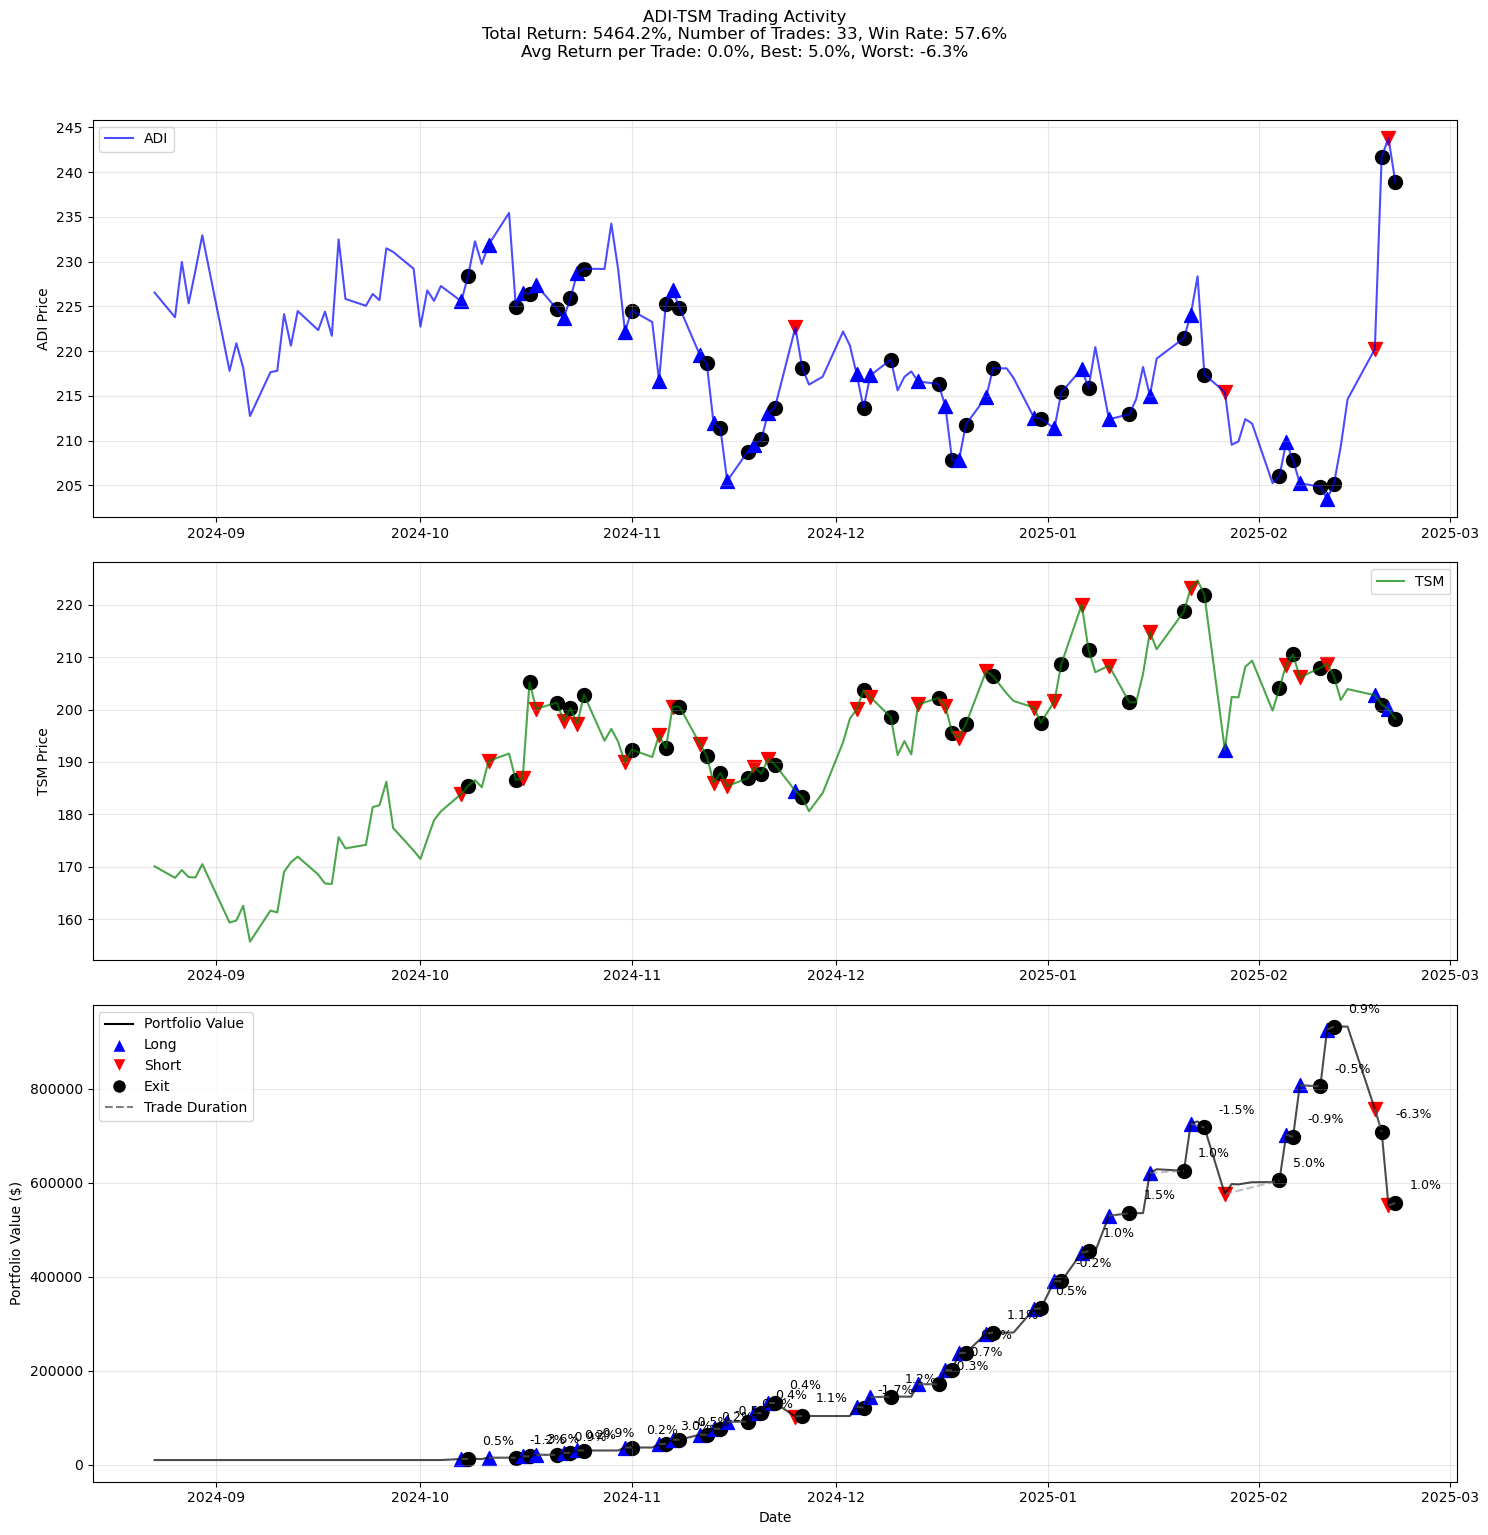

In [176]:
def plot_pair_trades(all_trades, test_df, pair_performances, pair_name):
    
    # Split pair name to get individual symbols
    S1_symbol, S2_symbol = pair_name.split('-')
    trades = all_trades[pair_name]
    pair_data = pair_performances[pair_name]
    
    if not trades:
        print(f"No trades found for pair {pair_name}")
        return
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), height_ratios=[1, 1, 1.2])
    
    # Plot price series
    ax1.plot(test_df.index, test_df[S1_symbol], 'b-', label=S1_symbol, alpha=0.7)
    ax2.plot(test_df.index, test_df[S2_symbol], 'g-', label=S2_symbol, alpha=0.7)
    ax3.plot(pair_data.index, pair_data['total_value'], 'k-', label='Portfolio Value', alpha=0.7)
    
    # Store min/max values for y-axis scaling
    min_value = pair_data['total_value'].min()
    max_value = pair_data['total_value'].max()
    
    for trade in trades:
        # If long or short S1 (and opposite for S2)
        is_S1_long = trade['S1_shares'] > 0
        
        # Entry points for S1
        ax1.scatter(trade['entry_date'], trade['entry_S1_price'], 
                   color='blue' if is_S1_long else 'red',
                   marker='^' if is_S1_long else 'v', s=100)
        
        # Exit points for S1
        ax1.scatter(trade['exit_date'], trade['exit_S1_price'], 
                   color='black', marker='o', s=100)
        
        # Entry points for S2
        ax2.scatter(trade['entry_date'], trade['entry_S2_price'], 
                   color='red' if is_S1_long else 'blue',
                   marker='v' if is_S1_long else '^', s=100)
        
        # Exit points for S2
        ax2.scatter(trade['exit_date'], trade['exit_S2_price'], 
                   color='black', marker='o', s=100)
        
        # Mark entry and exit on portfolio value plot
        entry_value = pair_data.loc[trade['entry_date'], 'total_value']
        exit_value = pair_data.loc[trade['exit_date'], 'total_value']
        
        # Plot entry and exit points on portfolio value
        ax3.scatter(trade['entry_date'], entry_value,
                   color='blue' if is_S1_long else 'red',
                   marker='^' if is_S1_long else 'v', s=100)
        ax3.scatter(trade['exit_date'], exit_value,
                   color='black', marker='o', s=100)
        
        # Add return annotation on portfolio value plot
        ax3.annotate(f"{trade['return']:.1f}%", 
                    xy=(trade['exit_date'], exit_value),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=9)
        
        # Draw connecting lines between entry and exit on portfolio value
        ax3.plot([trade['entry_date'], trade['exit_date']], 
                 [entry_value, exit_value], 
                 color='gray', linestyle='--', alpha=0.5)
    
    ax1.set_ylabel(f'{S1_symbol} Price')
    ax2.set_ylabel(f'{S2_symbol} Price')
    ax3.set_ylabel('Portfolio Value ($)')
    ax3.set_xlabel('Date')
    
    ax1.grid(True, alpha=0.3)
    ax2.grid(True, alpha=0.3)
    ax3.grid(True, alpha=0.3)
    

    returns = [t['return'] for t in trades]
    win_rate = sum(1 for r in returns if r > 0) / len(returns) * 100
    total_return = (pair_data['total_value'].iloc[-1] / pair_data['total_value'].iloc[0] - 1) * 100
    
    title = (f"{pair_name} Trading Activity\n"
             f"Total Return: {total_return:.1f}%, Number of Trades: {len(trades)}, Win Rate: {win_rate:.1f}%\n"
             f"Avg Return per Trade: {np.mean(returns):.1f}%, "
             f"Best: {max(returns):.1f}%, Worst: {min(returns):.1f}%")
    fig.suptitle(title, y=1.02)
    
    from matplotlib.lines import Line2D
    #Custom tag
    custom_lines = [
        Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=10, label='Long'),
        Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Short'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Exit')
    ]
    
    # Add legends
    ax1.legend([S1_symbol])
    ax2.legend([S2_symbol])
    
    # Custom legend for the third plot
    custom_lines_portfolio = [
        Line2D([0], [0], color='k', label='Portfolio Value'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=10, label='Long'),
        Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Short'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Exit'),
        Line2D([0], [0], color='gray', linestyle='--', label='Trade Duration')
    ]
    ax3.legend(handles=custom_lines_portfolio, loc='best')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
for pair_name in all_trades.keys():
    plot_pair_trades(all_trades, Test_df, pair_performances, pair_name)